In [19]:
import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image

In [20]:
#pip install torch===1.4.0 torchvision===0.5.0 -f https://download.pytorch.org/whl/torch_stable.html
#!pip install torchsummary

In [21]:
# Due to less dataset we are using different transform 

image_transforms = { 
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.CenterCrop(size=224),
        transforms.ColorJitter(brightness=1, contrast=0.5, saturation=0.3, hue=0.2), 
        transforms.RandomGrayscale(p=0.2), 
        transforms.Pad(2, fill=0, padding_mode='constant'), 
        transforms.RandomCrop(224, padding=None, pad_if_needed=False, fill=0, padding_mode='constant'),
        transforms.RandomPerspective(distortion_scale=0.2, p=0.3, interpolation=3),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [22]:
from torch.utils.data import DataLoader
# Load the Data
# Set train and valid directory paths
# As We have really less data we gonna use same dataset for validation and training

dataset = 'PhilipsContest' #path to dataset (In jupyter notebook i have datasets in 'PhilipsContest' folder)

train_directory = os.path.join(dataset)
valid_directory = os.path.join(dataset)
test_directory = os.path.join(dataset)

# Batch size
bs = 16

# Number of classes
num_classes = len(os.listdir(valid_directory))-1  
print(num_classes)

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid']),
    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
print(idx_to_class)

# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
valid_data_size = len(data['valid'])
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
train_data_loader = DataLoader(data['train'], batch_size=bs, shuffle=True)
valid_data_loader = DataLoader(data['valid'], batch_size=bs, shuffle=True)
test_data_loader = DataLoader(data['test'], batch_size=bs, shuffle=True)

4
{0: '.ipynb_checkpoints', 1: 'shaver', 2: 'smart-baby-bottle', 3: 'toothbrush', 4: 'wake-up-light'}


In [23]:
train_data_size, valid_data_size, test_data_size

(64, 64, 64)

In [24]:
# Load pretrained ResNet50 Model
resnet50 = models.resnet50(pretrained=True)
#resnet50 = resnet50.to('cuda:0')

In [25]:
# Freeze model parameters
for param in resnet50.parameters():
    param.requires_grad = False

In [26]:
# Change the final layer of ResNet50 Model for Transfer Learning
fc_inputs = resnet50.fc.in_features
 
resnet50.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 10), 
    nn.LogSoftmax(dim=1) # For using NLLLoss()
)

In [27]:
# Convert model to be used on GPU
#resnet50 = resnet50.to('cuda:0')

In [28]:
# Define Optimizer and Loss Function
loss_func = nn.NLLLoss()
optimizer = optim.Adam(resnet50.parameters())

In [29]:
import datetime
from datetime import datetime, date, time
import time

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(train_data_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(valid_data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/valid_data_size 
        avg_valid_acc = valid_acc/valid_data_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, dataset+'_model_'+str(epoch)+'.pt')
            
    return model, history

In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Print the model to be trained
summary(resnet50, input_size=(3, 224, 224), batch_size=bs, device='cuda')

# Train the model for 50 epochs
num_epochs = 25
trained_model, history = train_and_validate(resnet50, loss_func, optimizer, num_epochs)

torch.save(history, dataset+'_history.pt')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [16, 64, 112, 112]           9,408
       BatchNorm2d-2         [16, 64, 112, 112]             128
              ReLU-3         [16, 64, 112, 112]               0
         MaxPool2d-4           [16, 64, 56, 56]               0
            Conv2d-5           [16, 64, 56, 56]           4,096
       BatchNorm2d-6           [16, 64, 56, 56]             128
              ReLU-7           [16, 64, 56, 56]               0
            Conv2d-8           [16, 64, 56, 56]          36,864
       BatchNorm2d-9           [16, 64, 56, 56]             128
             ReLU-10           [16, 64, 56, 56]               0
           Conv2d-11          [16, 256, 56, 56]          16,384
      BatchNorm2d-12          [16, 256, 56, 56]             512
           Conv2d-13          [16, 256, 56, 56]          16,384
      BatchNorm2d-14          [16, 256,

Epoch : 000, Training: Loss: 1.9087, Accuracy: 18.7500%, 
		Validation : Loss : 1.3856, Accuracy: 25.0000%, Time: 58.3605s
Epoch: 2/25
Epoch : 001, Training: Loss: 1.5388, Accuracy: 23.4375%, 
		Validation : Loss : 1.1431, Accuracy: 39.0625%, Time: 59.0992s
Epoch: 3/25
Epoch : 002, Training: Loss: 1.2984, Accuracy: 45.3125%, 
		Validation : Loss : 0.9272, Accuracy: 65.6250%, Time: 66.7397s
Epoch: 4/25
Epoch : 003, Training: Loss: 1.3274, Accuracy: 40.6250%, 
		Validation : Loss : 0.8434, Accuracy: 68.7500%, Time: 58.9720s
Epoch: 5/25
Epoch : 004, Training: Loss: 1.1523, Accuracy: 53.1250%, 
		Validation : Loss : 0.7041, Accuracy: 84.3750%, Time: 57.0796s
Epoch: 6/25
Epoch : 005, Training: Loss: 1.0668, Accuracy: 54.6875%, 
		Validation : Loss : 0.7655, Accuracy: 64.0625%, Time: 67.2739s
Epoch: 7/25
Epoch : 006, Training: Loss: 0.9255, Accuracy: 60.9375%, 
		Validation : Loss : 0.6814, Accuracy: 70.3125%, Time: 68.0111s
Epoch: 8/25
Epoch : 007, Training: Loss: 0.8903, Accuracy: 68.7500%

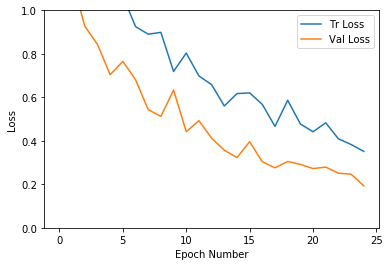

In [31]:
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.savefig(dataset+'_loss_curve.png')
plt.show()

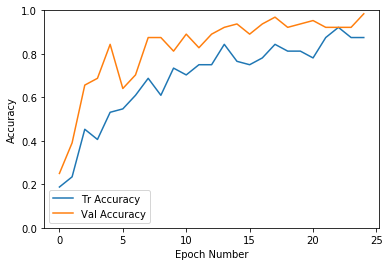

In [32]:
plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.savefig(dataset+'_accuracy_curve.png')
plt.show()

In [33]:
def computeTestSetAccuracy(model, loss_criterion):
    '''
    Function to compute the accuracy on the test set
    Parameters
        :param model: Model to test
        :param loss_criterion: Loss Criterion to minimize
    '''

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    test_acc = 0.0
    test_loss = 0.0

    # Validation - No gradient tracking needed
    with torch.no_grad():

        # Set to evaluation mode
        model.eval()

        # Validation loop
        for j, (inputs, labels) in enumerate(test_data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Compute the total loss for the batch and add it to valid_loss
            test_loss += loss.item() * inputs.size(0)

            # Calculate validation accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to valid_acc
            test_acc += acc.item() * inputs.size(0)

            print("Test Batch number: {:03d}, Test: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))

    # Find average test loss and test accuracy
    avg_test_loss = test_loss/test_data_size 
    avg_test_acc = test_acc/test_data_size

    print("Test accuracy : " + str(avg_test_acc))

In [34]:
def predict(model, test_image_name):
    '''
    Function to predict the class of a single test image
    Parameters
        :param model: Model to test
        :param test_image_name: Test image

    '''
    
    transform = image_transforms['test']

    test_image = Image.open(test_image_name)
    plt.imshow(test_image)
    
    test_image_tensor = transform(test_image)

    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224)
    
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(test_image_tensor)
        ps = torch.exp(out)
        topk, topclass = ps.topk(1, dim=1) # only first prediction will be shown
        for i in range(1):
            print("Predcition", ":", idx_to_class[topclass.cpu().numpy()[0][i]], ", Score: ", topk.cpu().numpy()[0][i])

In [35]:
# Test a particular model on a test image
#model = torch.load('PhilipsContest_model_1.pt') # Select he model you want to test
#predict(model,'Insert_Testing_Images/index3.jpg') # select any images to test the accuracy  

# Load Data from folders
#computeTestSetAccuracy(model, loss_func)

Predcition : wake-up-light , Score:  0.88738805
Predcition : toothbrush , Score:  0.44073397
Predcition : shaver , Score:  0.8715228
Predcition : wake-up-light , Score:  0.9835375
Predcition : toothbrush , Score:  0.9387039
Predcition : wake-up-light , Score:  0.9928572
Predcition : smart-baby-bottle , Score:  0.9431507
Predcition : smart-baby-bottle , Score:  0.97982204
Predcition : smart-baby-bottle , Score:  0.9653459
Predcition : smart-baby-bottle , Score:  0.9682684
Predcition : shaver , Score:  0.9998535
Predcition : smart-baby-bottle , Score:  0.98111385
Predcition : smart-baby-bottle , Score:  0.8411978
Predcition : smart-baby-bottle , Score:  0.9352665
Predcition : wake-up-light , Score:  0.9981804
Predcition : toothbrush , Score:  0.9471391
Predcition : smart-baby-bottle , Score:  0.8775734


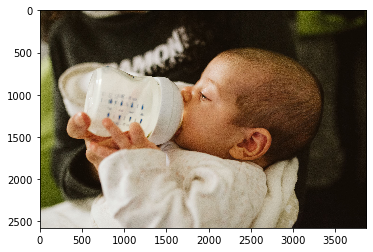

In [43]:
extensions = ['jpg','jpeg']
fileName = [image for image in os.listdir("Insert_Testing_Images") if any(image.endswith(ext) for ext in extensions)]
for file in fileName:        
    model = torch.load('PhilipsContest_model_48.pt') # Select he model you want to test
    predict(model,'Insert_Testing_Images/'+ file) # select any images to test the accuracy 